# Workflow: Histogram of musician ages at death (born 1945 - present)

# Workflow: Return list of category member pages

In [1]:
def return_cat_pages(categories, return_list = [], parent_list = [-99]):
    
    """
    Returns all pages associated with provided categories.
    Categories should be provided as (a list of) strings: 'LGBT musicians by nationality'
    """
    
    # create wikipedia api instance
    import wikipediaapi
    wiki_en = wikipediaapi.Wikipedia('en')
    
    for category in categories:
        try:
            # add 'Category:' before category name
            wiki_category = format_wiki_cat(category)
        except:
            print("Error! Check format_wiki_cat()")
        
        try:
            # does the page exist?
            wiki_page_exist = does_wiki_exist(wiki_category)
        except:
            print("Error! Check does_wiki_exist()")
        
        # Does wikipedia recognize the category?
        if wiki_page_exist == True:
                        
            # return all category members. pages and categories
            catmembers_dict = return_catmembers_dict(wiki_category)
            
            # return list of category members as pages only
            catmembers_list(catmembers_dict, return_list, parent_list)
            
        else:
            print("Does the", wiki_category, "exist?", wiki_page_exist)
     
    return return_list

## Dependencies

In [2]:
def format_wiki_cat(category):
    
    # add 'Category:' to proceed provided string
    format_name = str('Category:' + str(category))
    
    return format_name

In [3]:
def does_wiki_exist(name):
    """
    Given a name, check to see if a wikipedia page with that name exists
    """
    # create instance of wikipedia api
    import wikipediaapi
    wiki_en = wikipediaapi.Wikipedia('en')
    
    # get wikipedia page
    wiki_page = wiki_en.page(name)
    
    # does wikipedia page exist
    wiki_page_exist = wiki_page.exists()
    
    return wiki_page_exist

In [4]:
def return_catmembers_dict(page_name):
    """
    Given page name, return category members as dict
    """
    
    import wikipediaapi
    wiki_en = wikipediaapi.Wikipedia('en')
    
    wiki_page = wiki_en.page(page_name)
    catmembers_dict = wiki_page.categorymembers
    
    return catmembers_dict    

In [5]:
def catmembers_list(categorymembers, return_list, parent_list):
    """
    Using a dictionary of wikipedia page category members, return a list of all bottom category members (ns == 0)
    Provide an empty list that will be populated with bottom category members (return_list)
    Provide an empty list that will be populated with parent categories (parent_list)
    """
    
    import wikipediaapi
    wiki_en = wikipediaapi.Wikipedia('en')
    
    seen = set(return_list)  # functionality to prevent duplicates; code source: https://stackoverflow.com/questions/19834806/is-there-a-more-pythonic-way-to-prevent-adding-a-duplicate-to-a-list
    
    for c in categorymembers.values():
        
        # check for duplicates
        if c.title not in seen:
               
            if c.ns == 0:
                return_list.append(c.title)

            else:
                # sometimes category members do not begin with 'Category'; will result in read time error
                if c.title[0:8] != 'Category':
                    continue

                # some artists have categories; not interested in digging deeper
                if c.title == parent_list[-1]:
                    continue

                # some categories are empty; will result in read time error
                wiki_page = wiki_en.page(c.title)
                catmembers_dict = wiki_page.categorymembers
                if catmembers_dict == {}:
                    continue

                # keep track of previous categories - helps with debugging
                parent_list.append(c.title)
                
                # keep digging down
                catmembers_list(c.categorymembers, return_list, parent_list)
            
    return return_list

# Workflow: Return Age at Death

In [6]:
def death_age(page_list):
    """
    Given a list of wikipedia page names, return a dictionary = ['Person Name']:Age at death
    """
    
    # Requirements
    import pandas as pd
    
    # Create an empty dictionary to be filled
    age_at_death = {}
    
    for page in page_list:
        
        try:
            person_dates = person_born_dead(page)
            
            if len(person_dates.values()) == 2:  # only if both birth and death date are present
                birth = pd.to_datetime(person_dates['Born'])
                death = pd.to_datetime(person_dates['Dead'])
                
                death_age = calculate_age(birth, death)  # factoring for partial years calculate age at death
                
                age_at_death[page] = death_age  # add an element to the dictionary
                    
        except:
            continue  # skip page if doesn't have birth and death date
        
    return age_at_death

## Dependencies

In [70]:
# v002

def person_born_dead(person_name):
    """
    Provided with a Wikipedia Page Name (str) (e.g., 'Jim Morrison')
    Return a set(Date born, Date died)
    """
    import requests
    import re
    
    try:
        wiki_url = create_wiki_url(person_name)
    except:
        print(person_name, "Error. Check create_wiki_url()")
        
    try:
        text = scrape_wiki_page(wiki_url)
    except:
        print(person_name, "Error. Check scrape_wiki_page()")
    
    try:
        page_slice = return_page_slice(text)
    except:
        print(person_name, "Check out: return_page_slice()")
    
    try:
        # create an empty set to have dates added to; set protects against dups
        dates = []
        dates_dict = {}
        
        pattern01 = re.compile(r'\b\w{3,9}\s\d{1,2}\W\s\d{4}')  # Month Date, Year
        pattern02 = re.compile(r'\b\d{1,2}\s\w{3,9}\s\d{4}')  # Date Month Year
        
        
        matches01 = pattern01.finditer(page_slice)
        matches02 = pattern02.finditer(page_slice)
        
        # pattern 01 was matched, append to dates
        for match in matches01:
            
            # protect against duplicates
            if match.group(0) not in dates:
                dates.append(match.group(0))
        
        # if pattern 01 was not matched, try pattern 02
        if len(dates) == 0:
            
            for match in matches02:
                # protect against duplicates
                if match.group(0) not in dates:
                    dates.append(match.group(0))
                
        # create a tuple, avoids sorting of dates
        dates_tuple = tuple(dates)
        
        # store in a dictionary
        titles = ('Born', 'Dead')
        
        for title, match in zip(titles, dates_tuple):
            dates_dict[title] = match

        return dates_dict
    
    except:
        print(person_name, "is not a human! function: person_born_dead")

In [8]:
def create_wiki_url(page_name):
    url = "http://en.wikipedia.org/wiki/"
    format_page_name = page_name.strip().replace(" ","_")
    
    wiki_url = url + format_page_name
        
    return wiki_url

In [9]:
def scrape_wiki_page(wiki_url):
    """
    Given wikipedia url, return scraped text
    """
    
    import requests

    wiki_page = requests.get(wiki_url)
    wiki_page_text = wiki_page.text
    
    return wiki_page_text

In [10]:
def return_page_slice(text, start_point = "Born", end_point = 1000):
    """
    Given scraped html page and a start point
    Return a page slice
    """

    start = text.find(start_point) + len(start_point)
    end = start + end_point
    page_slice = text[start:end] #slice after born
        
    return page_slice

In [11]:
# code source: https://stackoverflow.com/questions/2217488/age-from-birthdate-in-python

def calculate_age(born, died):
    """
    Give date at birth and death, return age
    """
    
    from datetime import date
    
    age_at_death = died.year - born.year - ((died.month, died.day) < (born.month, born.day))
    
    return age_at_death

## Execute

In [15]:
import time

In [12]:
categories = ['Male musicians by nationality', 'Female musicians by nationality', 'LGBT musicians by nationality']

In [16]:
start = time.time()

cat_pages = return_cat_pages(categories)

end = time.time()

In [22]:
time_taken = (end - start) / 60
time_taken

49.064732623100284

In [71]:
f'The Wikipedia API returned {len(cat_pages)} pages under those categories.'

'The Wikipedia API returned 76346 pages under those categories.'

In [72]:
start = time.time()

musician_age_at_death = death_age(cat_pages)

end = time.time()

In [73]:
time_taken = ((end - start) / 60)/60
time_taken

10.90517928050624

In [89]:
f'The Wikipedia API returned {len(list(musician_age_at_death.keys()))} pages (age of death).'

'The Wikipedia API returned 9727 pages (age of death).'

## **Save**

In [96]:
import json

In [97]:
with open('musician_age_at_death.json', 'w') as fp:
    json.dump(musician_age_at_death, fp)

## **Load**

In [99]:
with open('musician_age_at_death.json', 'r') as fp:
    data = json.load(fp)

In [100]:
f'The Wikipedia API returned {len(list(data.keys()))} pages (age of death).'

'The Wikipedia API returned 9727 pages (age of death).'

## Test **Random Samples**

In [75]:
length = len(list(musician_age_at_death.keys())) # number of keys in dict

import random

In [81]:
onesample = random.choice(list(musician_age_at_death.items()))

f'The dictionary has {length} elements of the following form: {onesample}'

"The dictionary has 9727 elements of the following form: ('Pavel Bobek', 76)"

## Test **Zero Values**

In [82]:
musicians_zero_age = {}

for musician in musician_age_at_death:
    if musician_age_at_death[musician] == 0:
        musicians_zero_age[musician] = musician_age_at_death[musician]

f'The Wikipedia API returned {len(list(musicians_zero_age.keys()))} pages (age of death).'

'The Wikipedia API returned 65 pages (age of death).'

## Filter **Greater Than 15**

In [83]:
musicians_15_plus = {}

for musician in musician_age_at_death:
    if musician_age_at_death[musician] >= 15:
        musicians_15_plus[musician] = musician_age_at_death[musician]

f'The Wikipedia API returned {len(list(musicians_15_plus.keys()))} pages (age of death).'

'The Wikipedia API returned 9519 pages (age of death).'

## Histogram

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [85]:
dataset = musicians_15_plus

In [86]:
length = len(list(dataset.keys())) # number of keys in dict
n_bins = int(np.sqrt(length))

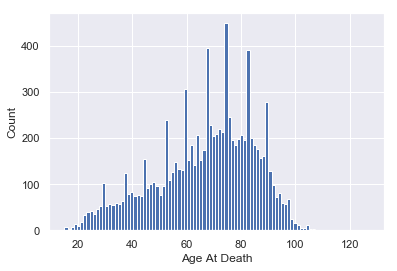

In [87]:
sns.set()
_ = plt.hist(dataset.values(), bins = n_bins)

_ = plt.xlabel('Age At Death')
_ = plt.ylabel('Count')

plt.show()

# Summary

Is this equal to a global person distribution?

What's with the long bins?

Format the y-variable to percents